In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
torch.set_default_dtype(torch.float64)
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go

c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


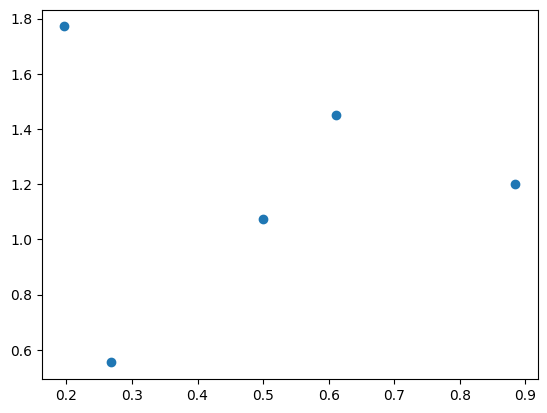

In [2]:
# # Generating inital values for Wall slip parameters

# #tau_w_range = [0.001, 1] 0.001 , 2
# # #m_range = [0.5, 2]     0.1 , 2,5

lower= [0.001, 0.5]
upper = [1.0, 2.0]

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(5)

scaled_values = qmc.scale(sample, lower, upper)
tau_w_values = scaled_values[:,0]
m_values = scaled_values[:,1]
plt.scatter(tau_w_values, m_values)
plt.show()

LHS_data = pd.DataFrame({
    'tau_w_values': tau_w_values,
    'm_values': m_values
})
LHS_data.to_csv('tau_w_and_m_values.csv', index=False)

In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse

file_directory = Path("H:\\XMLFiles")
real_data_directory = "H:\\Real_data\\press_displacement_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1] * 1000 




In [4]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"                        #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  


Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
Project = Synergy.Project
Project.OpenItemByName("60SurfaceCoverage_study", "Study")

# Simulation loop for wall slip parameters
for i in range(5):
    tau_w = tau_w_values[i]
    m = m_values[i]
    print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

    study_name =f"study_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\study_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"study_{i+1}", "Study")


    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}.xml", "Metric")
    
    


    
# Write the output to a log file
    with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with tau_w : 0.6105672695532495 and m: 1.4518954870923355
Simulation 2 with tau_w : 0.8846551781419889 and m: 1.2003692820413268
Simulation 3 with tau_w : 0.19692052275429076 and m: 1.771403200834503
Simulation 4 with tau_w : 0.4993271742480181 and m: 1.0754470155587461
Simulation 5 with tau_w : 0.2678293061542229 and m: 0.5540935479855874


In [5]:
## CAREFUL ONLY APPEND 1 TIME

for i in range(5):
        guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                guess_data.append((time_value, dept_value))

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]

        globals()[f"guess_time_{i+1}"] = guess_time
        globals()[f"guess_disp_{i+1}"] = guess_disp
    
    
        mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
        area_data.append(mean_s_error)
print(guess_data_all)


{'guess_data_1': [('0.019225', '9.6125e-03'), ('0.152085', '7.6043e-02'), ('0.423948', '2.1197e-01'), ('0.678510', '3.3925e-01'), ('0.862947', '4.3147e-01'), ('1.079679', '5.3984e-01'), ('1.289728', '6.4486e-01'), ('1.434668', '7.1733e-01'), ('1.584021', '7.9201e-01'), ('1.753659', '8.7683e-01'), ('1.878889', '9.3944e-01'), ('2.033547', '1.0168e+00'), ('2.171174', '1.0856e+00'), ('2.290683', '1.1453e+00'), ('2.407707', '1.2039e+00'), ('2.607085', '1.3035e+00'), ('2.800056', '1.4000e+00'), ('2.932251', '1.4661e+00'), ('3.047292', '1.5236e+00'), ('3.162298', '1.5811e+00'), ('3.271177', '1.6356e+00'), ('3.373667', '1.6868e+00'), ('3.476597', '1.7383e+00'), ('3.579626', '1.7898e+00'), ('3.675667', '1.8378e+00'), ('3.724614', '1.8623e+00'), ('3.733716', '1.8669e+00'), ('3.743309', '1.8717e+00'), ('3.745641', '1.8685e+00'), ('3.750304', '1.8690e+00'), ('3.753309', '1.8692e+00'), ('3.754309', '1.8693e+00'), ('3.756309', '1.8695e+00'), ('3.760309', '1.8697e+00'), ('3.768309', '1.8702e+00'), ('

In [6]:
print(real_disp)
print(area_data)

[0.0096125 0.076043  0.21197   0.3431    0.43704   0.54768   0.6537
 0.72772   0.79759   0.88744   0.96138   1.0271    1.0991    1.1594
 1.2605    1.3584    1.4181    1.4802    1.5374    1.5943    1.6467
 1.6975    1.7483    1.7985    1.8468    1.8702    1.8759    1.872
 1.8723    1.8724    1.8725    1.8728    1.8733    1.8739    1.8748
 1.8758    1.8767    1.8764    1.8732    1.8688    1.8642    1.862
 1.8609    1.8598    1.8589    1.8584    1.8581    1.8579    1.8579
 1.8579    1.8579    1.8579    1.8579    1.8579    1.8579   ]
[np.float64(9.228163014629719e-06), np.float64(9.88259442162972e-06), np.float64(5.3467729205900154e-06), np.float64(1.0428690719147176e-05), np.float64(0.00013570514215360742)]


In [7]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(9.228163014629719e-06), np.float64(9.88259442162972e-06), np.float64(5.3467729205900154e-06), np.float64(1.0428690719147176e-05), np.float64(0.00013570514215360742)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5']
guess_data_1: Shape = (57, 2)
guess_data_2: Shape = (55, 2)
guess_data_3: Shape = (55, 2)
guess_data_4: Shape = (55, 2)
guess_data_5: Shape = (56, 2)


In [8]:
file_path = 'H:\\moldflow\\moldflow_automation\\tau_w_and_m_values.csv'  
data = pd.read_csv(file_path)
tau_w_values = data['tau_w_values'].values
m_values = data['m_values'].values
area_data_optimization = []
train_x = torch.tensor([[tau_w_values[0], m_values[0]], [tau_w_values[1], m_values[1]], [tau_w_values[2], m_values[2]], [tau_w_values[3], m_values[3]], [tau_w_values[4], m_values[4]]])
train_y = -torch.tensor([[area_data[0]], [area_data[1]], [area_data[2]], [area_data[3]], [area_data[4]]])
train_yvar = torch.full_like(train_y, 1e-11)
bounds = torch.tensor([
    lower, #Lower bounds
    upper    #Upper Bounds
], dtype=torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=2)

# Optimization
model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()    

acq_func =  LogExpectedImprovement(model, best_f=train_y.max())
# acq_func =  qLogExpectedImprovement(model, best_f=train_y.max())

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
        raw_samples=5120,  #More samples increases likelihood of finding good starting point.
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)

In [9]:
print(candidate)
print(train_y)
print(train_x)


tensor([[1.0000e-03, 1.2892e+00]])
tensor([[-9.2282e-06],
        [-9.8826e-06],
        [-5.3468e-06],
        [-1.0429e-05],
        [-1.3571e-04]])
tensor([[0.6106, 1.4519],
        [0.8847, 1.2004],
        [0.1969, 1.7714],
        [0.4993, 1.0754],
        [0.2678, 0.5541]])


In [10]:
with torch.no_grad():
    #Generate grid for plotting
    x_grid, y_grid = np.meshgrid(
        np.linspace(bounds[0, 0].item(), bounds[0, 1].item(), 50),
        np.linspace(bounds[1, 0].item(), bounds[1, 1].item(), 50),
    )
    val_X_grid_tensor = torch.tensor(
        np.column_stack((x_grid.ravel(), y_grid.ravel())),
        dtype=torch.float64,
    )
    #plt.scatter(x_grid, y_grid)
    #plt.show()
    val_X_grid_tensor = input_transform(val_X_grid_tensor)

    #GP predictions on the grid
    pred_Y = model(val_X_grid_tensor)
    pred_Yvar = torch.diagonal(pred_Y.covariance_matrix, 0)
    pred_mean, pred_var = outcome_transform.untransform(pred_Y.mean, pred_Yvar)
    #pred_mean = pred_Y.mean
    #pred_var = pred_Yvar
    pred_mean = pred_mean.detach().numpy().reshape(x_grid.shape)
    pred_std = torch.sqrt(pred_var).detach().numpy().reshape(x_grid.shape)
    


# Check if the unit conversions are right from moldflow export

In [11]:

# common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
# real_disp_resampled = np.interp(common_time, real_time, real_disp)
# guess_1_disp_resampled = np.interp(common_time, guess_time_1, guess_disp_1)
# guess_2_disp_resampled = np.interp(common_time, guess_time_2, guess_disp_2)
# guess_3_disp_resampled = np.interp(common_time, guess_time_3, guess_disp_3)
# guess_4_disp_resampled = np.interp(common_time, guess_time_4, guess_disp_4)
# guess_5_disp_resampled = np.interp(common_time, guess_time_5, guess_disp_5)
# plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
# plt.plot(common_time, guess_1_disp_resampled, 'g-',label = 'Guess_1' )
# plt.plot(common_time, guess_2_disp_resampled, 'r-',label = 'Guess_2' )
# plt.plot(common_time, guess_3_disp_resampled, 'y-',label = 'Guess_3' )
# plt.plot(common_time, guess_4_disp_resampled, 'c-',label = 'Guess_4' )
# plt.plot(common_time, guess_5_disp_resampled, 'k-',label = 'Guess_5' )
# plt.legend(loc='best')
# plt.xlabel('Time s')
# plt.ylabel('Press Dispalcement')
# # plt.ylim(1.84 ,1.88)
# plt.title('Press Displacement vs Time')
# plt.show()
# plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
# plt.legend(loc='best')
# plt.xlabel('Time s')
# plt.ylabel('Press Dispalcement')
# plt.title('Press Displacement vs Time')
# plt.show()


In [12]:
fig = go.Figure()



fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean,
    colorscale='Viridis', opacity=0.6, name="GP Mean"
))


fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean + pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean + Std"
))


fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean - pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean - Std"
))


fig.add_trace(go.Scatter3d(
    x=train_x[:, 0].numpy(),
    y=train_x[:, 1].numpy(),
    z=train_y.flatten().numpy(),
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Training Data'
))

fig.add_trace(go.Scatter3d(
    x=[0.1],
    y=[1],
    z=[0],
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Ground truth'
)
)

for i in range(candidate.shape[0]):  
    
    cand = model(input_transform(candidate[i].unsqueeze(0)))
    cand_var = torch.diagonal(cand.covariance_matrix, 0)
    cand_mean, _ = outcome_transform.untransform(cand.mean, cand_var)
    
    
    fig.add_trace(go.Scatter3d(
        x=[candidate[i, 0].item()],
        y=[candidate[i, 1].item()],
        z=[cand_mean.item()],
        mode='markers',
        marker=dict(size=8, color='red'),
        name=f'Candidate {i + 1}'
    ))


fig.update_layout(
    scene=dict(
        xaxis_title="Critical shear stress (Tau_W)",
        yaxis_title="Slip exponent (m)",
        zaxis_title="Predicted Value (mse)"
        
        
    ),
    title="Interactive GP Model Predictions with Uncertainty and Candidates",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()
fig.write_html("gp_model_predictions.html")


In [13]:
print(train_y)

tensor([[-9.2282e-06],
        [-9.8826e-06],
        [-5.3468e-06],
        [-1.0429e-05],
        [-1.3571e-04]])


In [14]:

tau_w_range = torch.linspace(bounds[0, 0], bounds[0, 1], 100)  # Grid for tau_w
m_range = torch.linspace(bounds[1, 0], bounds[1, 1], 100)      # Grid for m
tau_w_grid, m_grid = torch.meshgrid(tau_w_range, m_range, indexing="ij")


grid = torch.stack([tau_w_grid.ravel(), m_grid.ravel()], dim=-1)


acq_values = acq_func(grid.unsqueeze(1)).detach().numpy().reshape(100, 100)


train_acq_values = acq_func(train_x.unsqueeze(1)).detach().numpy()


fig = go.Figure()


fig.add_trace(go.Surface(
    x=tau_w_grid.numpy(),
    y=m_grid.numpy(),
    z=acq_values,
    colorscale='Viridis',
    opacity=0.6,
    name="Acquisition Function"
))


fig.add_trace(go.Scatter3d(
    x=train_x[:, 0].numpy(),
    y=train_x[:, 1].numpy(),
    z=train_acq_values.flatten(),
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Training Data'

))

fig.add_trace(go.Scatter3d(
    x=[0.1],
    y=[1],
    z=[acq_values.max()] ,
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Ground truth'
)
)

#Iterate over the candidates
for i in range(candidate.shape[0]): 
    candidate_acq_value = acq_func(candidate[i].unsqueeze(0)).item()
    fig.add_trace(go.Scatter3d(
        x=[candidate[i, 0].item()],
        y=[candidate[i, 1].item()],
        z=[candidate_acq_value],
        mode='markers',
        marker=dict(size=8, color='red', symbol='circle'),
        name=f'Candidate {i + 1}'
    ))



fig.update_layout(
    scene=dict(
        xaxis_title="Critical shear stress (Tau_W)",
        yaxis_title="Slip exponent (m)",
        zaxis_title="Acquisition Value"
    ),
    title="Interactive Acquisition Function",
    margin=dict(l=0, r=0, b=0, t=40)
)


fig.show()
fig.write_html("acquisiton_func.html")


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning:

Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.



## NOTES

# Try new sampling values
# Check for the Press Force curves

In [15]:
# Optimization
guess_data_all_optim = {}
num_iteration = 3
iterations=[]
#tolerance = 1e-12

for i in range(num_iteration):
    # Optimization
    # model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    # mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # fit_gpytorch_mll(mll)
    # model.eval()    

    # acq_func =  LogExpectedImprovement(model, best_f=train_y.max())
    # # acq_func =  qLogExpectedImprovement(model, best_f=train_y.max())

    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5120,  #More samples increases likelihood of finding good starting point.
    )    

    print(f"Iteration {i+1}: Suggested new parameters (tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    study_name = f"optimization_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate_optim[0,0].item())
    DVec.AddDouble(candidate_optim[0,1].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")
    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)
    
    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\optimization_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")
    


    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []
    time.sleep(10)    
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))

    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  
        
    globals()[f"guess_time_{4 + num_iteration}"] = guess_time
    globals()[f"guess_disp_{4 + num_iteration}"] = guess_disp
    
    mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(mean_s_error)


    
# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    train_x = torch.cat([train_x, candidate_optim], dim=0)
    train_y = torch.cat([train_y, -torch.tensor([[area_data[-1]]])], dim=0)
    train_yvar = torch.full_like(train_y, 1e-11)
    current_best_area = train_y.min().item()

    if abs(current_best_area) < 1e-9:
        print(f"Converged after {i+1} iteration")
        break

    

best_params = train_x[train_y.argmax()]
best_area = train_y.min().item()
print(f"Best parameters (tau_w, m): {best_params}, with MSE : {best_area}")

Iteration 1: Suggested new parameters (tau_w, m) tensor([[1.0000e-03, 1.2892e+00]])
Iteration 2: Suggested new parameters (tau_w, m) tensor([[1.0000e-03, 1.2892e+00]])
Iteration 3: Suggested new parameters (tau_w, m) tensor([[1.0000e-03, 1.2892e+00]])
Best parameters (tau_w, m): tensor([0.1969, 1.7714]), with MSE : -0.00013570514215360742


In [16]:
print(train_y)
print(train_x)

tensor([[-9.2282e-06],
        [-9.8826e-06],
        [-5.3468e-06],
        [-1.0429e-05],
        [-1.3571e-04],
        [-2.8153e-05],
        [-2.8153e-05],
        [-2.8153e-05]])
tensor([[6.1057e-01, 1.4519e+00],
        [8.8466e-01, 1.2004e+00],
        [1.9692e-01, 1.7714e+00],
        [4.9933e-01, 1.0754e+00],
        [2.6783e-01, 5.5409e-01],
        [1.0000e-03, 1.2892e+00],
        [1.0000e-03, 1.2892e+00],
        [1.0000e-03, 1.2892e+00]])


In [17]:
print(iterations)

[tensor([[1.0000e-03, 1.2892e+00]]), tensor([[1.0000e-03, 1.2892e+00]]), tensor([[1.0000e-03, 1.2892e+00]])]
